In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

## Dataset

In [3]:
start_date = '2023-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
stock_ticker = 'NVDA'

df = yf.download(stock_ticker, start=start_date, end=end_date)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
0,2023-01-03,14.303280,14.983723,14.084459,14.838841,401277000
1,2023-01-04,14.736923,14.840838,14.229340,14.555073,431324000
2,2023-01-05,14.253321,14.552076,14.136416,14.479135,389168000
3,2023-01-06,14.846834,14.997711,14.022510,14.462149,405044000
4,2023-01-09,15.615206,16.042855,15.128604,15.271488,504231000


In [4]:
df.columns = df.columns.droplevel(1)
df.columns.name = None

df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

df = df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
df = df.reset_index(drop=True)

df.head()

,Date,Close
0,2023-01-03,14.838841
1,2023-01-04,14.555073
2,2023-01-05,14.479135
3,2023-01-06,14.462149
4,2023-01-09,15.271488


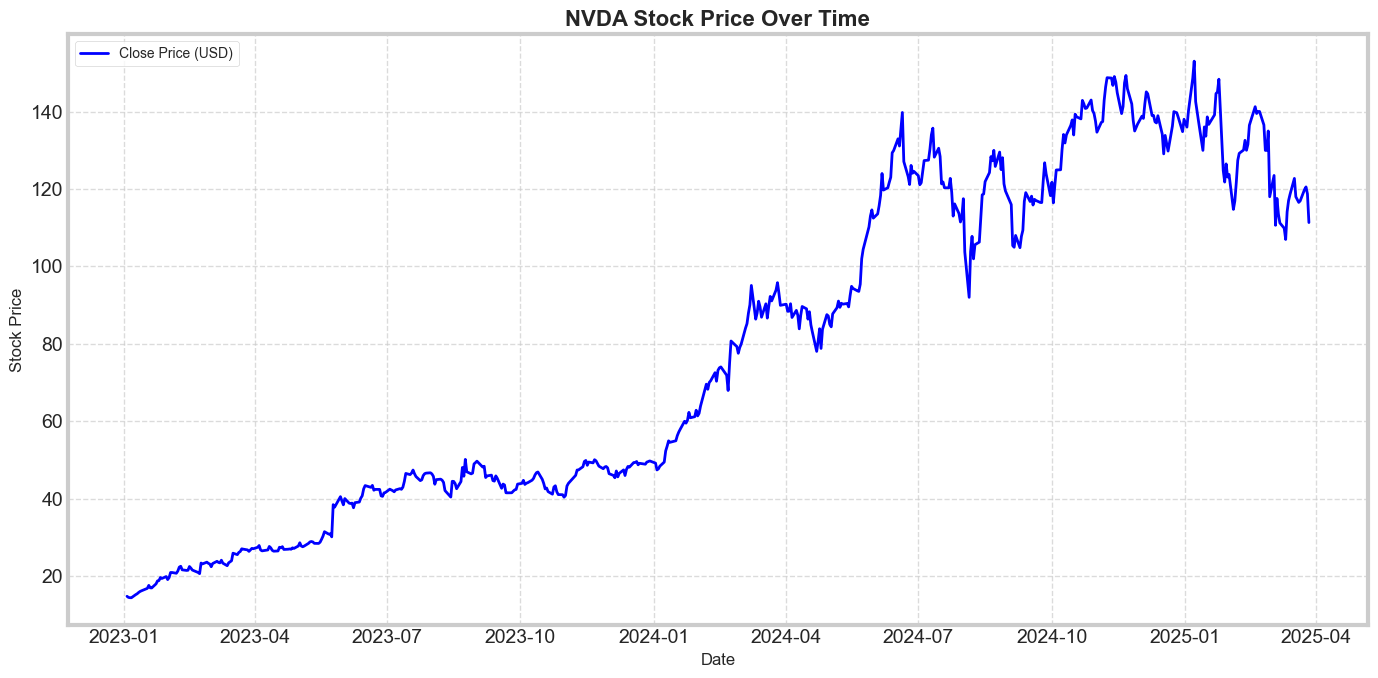

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price (USD)', color='blue', linewidth=2)
plt.title(f'{stock_ticker} Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Add features for improved model

In [6]:
def add_features(df):
  df_copy = df.copy()

  # Lagged Closing Prices
  df_copy["Close_Lag1"] = df_copy["Close"].shift(1)
  df_copy["Close_Lag2"] = df_copy["Close"].shift(2)
  df_copy["Close_Lag3"] = df_copy["Close"].shift(3)

  # Moving Averages - shift by 1 to avoid using current day
  df_copy["MA5"] = df_copy["Close"].shift(1).rolling(window=5).mean()
  df_copy["MA10"] = df_copy["Close"].shift(1).rolling(window=10).mean()
  df_copy["MA20"] = df_copy["Close"].shift(1).rolling(window=20).mean()

  # Exponential Moving Averages - shift by 1
  df_copy["EMA12"] = df_copy["Close"].shift(1).ewm(span=12, adjust=False).mean()
  df_copy["EMA26"] = df_copy["Close"].shift(1).ewm(span=26, adjust=False).mean()
  df_copy["MACD"] = df_copy["EMA12"] - df_copy["EMA26"]
  df_copy["Signal_Line"] = df_copy["MACD"].ewm(span=9, adjust=False).mean()

  # Volatility - shift by 1
  df_copy["Volatility"] = df_copy["Close"].shift(1).rolling(window=10).std()

  # Rate of Change - shift by 1
  df_copy["ROC"] = df_copy["Close"].shift(1).pct_change(periods=10) * 100
  df_copy['ROC_Acceleration'] = df_copy['ROC'].diff()
  df_copy['ROC_MA5'] = df_copy['ROC'].rolling(window=5).mean()

  return df_copy

In [7]:
df = add_features(df)
df = df.dropna()

df.tail()

,Date,Close,Close_Lag1,Close_Lag2,Close_Lag3,MA5,MA10,MA20,EMA12,EMA26,MACD,Signal_Line,Volatility,ROC,ROC_Acceleration,ROC_MA5
555,2025-03-21,116.940002,116.550003,117.269997,118.000000,118.634000,115.242982,120.358721,117.905632,121.515043,-3.609411,-4.133249,4.694800,2.669537,2.924018,1.792459
556,2025-03-24,119.879997,116.940002,116.550003,117.269997,118.300000,115.813005,119.204365,117.757073,121.176151,-3.419077,-3.990415,4.496607,5.124274,2.454737,2.715482
557,2025-03-25,120.550003,119.879997,116.940002,116.550003,117.728000,116.812016,118.370993,118.083677,121.080139,-2.996462,-3.791624,4.129194,9.091015,3.966741,4.656543
558,2025-03-26,118.730003,120.550003,119.879997,116.940002,118.238000,118.169000,117.900091,118.463112,121.040870,-2.577758,-3.548851,2.411667,12.684450,3.593435,5.862959
559,2025-03-27,111.345001,118.730003,120.550003,119.879997,118.530002,118.630000,117.337688,118.504172,120.869695,-2.365523,-3.312185,1.947659,4.039608,-8.644842,6.721777


## Tesla Stock Price Prediction

### Gradient Boosting Regression

In [8]:
class GradientBoostingRegressor:
    def __init__(self, n_trees=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample=0.8, l2_reg=0.1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.H = None
        self.validation_scores = []
        self.training_scores = []
        self.best_n_trees = None
        self.tree_learning_rates = []
        self.subsample = subsample
        self.colsample = colsample
        self.l2_reg = l2_reg
        self.feature_importances_ = None
        
    def _negative_gradient(self, y, H):
        return y - H
    
    def _build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1:
            return np.mean(y)
        
        best_feature, best_threshold, best_mse = None, None, float('inf')
        best_split = None

        n_thresholds = 30
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            unique_vals = np.unique(X[:, feature_idx])
            if len(unique_vals) > n_thresholds:
                percentiles = np.linspace(0, 100, n_thresholds)
                sampled_thresholds = np.percentile(unique_vals, percentiles)
            else:
                sampled_thresholds = unique_vals
            
            for threshold in sampled_thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if not np.any(left_mask) or not np.any(right_mask):
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                left_mean, right_mean = np.mean(y_left), np.mean(y_right)
                
                n_left, n_right = len(y_left), len(y_right)
                left_mean_reg = left_mean * n_left / (n_left + self.l2_reg)
                right_mean_reg = right_mean * n_right / (n_right + self.l2_reg)
                
                mse = (np.sum((y_left - left_mean_reg) ** 2) + 
                       np.sum((y_right - right_mean_reg) ** 2))
                
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_split = (left_mask, right_mask)
    
        if best_split is None:
            return np.mean(y)
        
        left_subtree = self._build_tree(X[best_split[0]], y[best_split[0]], depth + 1)
        right_subtree = self._build_tree(X[best_split[1]], y[best_split[1]], depth + 1)
        
        return (best_feature, best_threshold, left_subtree, right_subtree)
    
    def _predict_tree(self, tree_data, x):
        tree, feature_subset = tree_data
        
        if feature_subset is not None:
            x_subset = x[feature_subset]
        else:
            x_subset = x
            
        if isinstance(tree, (int, float)):
            return tree
        
        feature, threshold, left_subtree, right_subtree = tree
        
        if x_subset[feature] <= threshold:
            return self._predict_tree((left_subtree, feature_subset), x)
        else:
            return self._predict_tree((right_subtree, feature_subset), x)
        
    def _calculate_mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def _should_stop_early(self, iteration):
        if len(self.validation_scores) < 5:
            return False
        
        best_score_idx = np.argmin(self.validation_scores)
        self.best_n_trees = best_score_idx + 1
        
        patience = 10
        if (iteration - best_score_idx) >= patience:
            return True
        
        recent_scores = self.validation_scores[-5:]
        if (max(recent_scores) - min(recent_scores)) / (min(recent_scores) + 1e-10) < 0.001:
            return True
        
        return False
    
    def _calculate_adaboost_rate(self, residuals, tree_preds):
        errors = (residuals - tree_preds) ** 2   
        mse = np.sum(errors) / np.sum(residuals ** 2)      
        mse = np.clip(mse, 1e-10, 1 - 1e-10) 
        dampening_factor = 0.5
        alpha = dampening_factor * 0.5 * np.log((1 - mse) / mse)
        min_lr = 0.01
        return max(self.learning_rate * alpha, min_lr)

    def _get_tree_learning_rate(self, idx):
        if idx < len(self.tree_learning_rates):
            return self.tree_learning_rates[idx]
        return self.learning_rate
    
    def _update_feature_importance(self, tree_data):
        tree, feature_subset = tree_data
        
        if isinstance(tree, (int, float)):
            return
        
        feature, threshold, left_subtree, right_subtree = tree
        actual_feature = feature_subset[feature] if feature_subset is not None else feature
        
        self.feature_importances_[actual_feature] += 1
        
        self._update_feature_importance((left_subtree, feature_subset))
        self._update_feature_importance((right_subtree, feature_subset))
        
    def fit(self, X, y, X_val=None, y_val=None):
        mean_y = np.mean(y)
        self.H = np.full(y.shape, mean_y)
        
        self.tree_learning_rates = []
        self.training_scores = []
        self.validation_scores = []
        self.feature_importances_ = np.zeros(X.shape[1])
        
        val_predictions = None
        if X_val is not None and y_val is not None:
            val_predictions = np.full(y_val.shape, mean_y)
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        with tqdm(total=self.n_trees, desc="Training Progress", unit="tree") as pbar:
            for iteration in range(self.n_trees):                
                residuals = self._negative_gradient(y, self.H)
                
                if self.subsample < 1.0:
                    sample_indices = np.random.choice(n_samples, 
                                                     size=int(n_samples * self.subsample), 
                                                     replace=False)
                    X_subset = X[sample_indices]
                    residuals_subset = residuals[sample_indices]
                else:
                    X_subset = X
                    residuals_subset = residuals
                    sample_indices = np.arange(n_samples)
                    
                if self.colsample < 1.0:
                    feature_indices = np.random.choice(n_features, 
                                                      size=int(n_features * self.colsample), 
                                                      replace=False)
                    X_filtered = X_subset[:, feature_indices]
                else:
                    X_filtered = X_subset
                    feature_indices = None
                
                tree = self._build_tree(X_filtered, residuals_subset)
                self.trees.append((tree, feature_indices))
                
                self._update_feature_importance((tree, feature_indices))
                
                tree_preds = np.zeros(len(X))
                for i in range(len(X)):
                    tree_preds[i] = self._predict_tree((tree, feature_indices), X[i])
            
                current_learning_rate = self._calculate_adaboost_rate(residuals, tree_preds)
                self.tree_learning_rates.append(current_learning_rate)
            
                for i in range(len(X)):
                    self.H[i] += current_learning_rate * self._predict_tree((tree, feature_indices), X[i])
                    
                train_mse = self._calculate_mse(y, self.H)
                self.training_scores.append(train_mse)
                
                if X_val is not None and y_val is not None:
                    for i in range(len(X_val)):
                        val_predictions[i] += current_learning_rate * self._predict_tree((tree, feature_indices), X_val[i])
                    
                    val_mse = self._calculate_mse(y_val, val_predictions)
                    self.validation_scores.append(val_mse)
                    
                    pbar.set_postfix({"train_mse": f"{train_mse:.4f}", "val_mse": f"{val_mse:.4f}", "lr": f"{current_learning_rate:.4f}"})
                    
                    if self._should_stop_early(iteration):
                        pbar.write(f"Early stopping at iteration {iteration}. Best n_trees: {self.best_n_trees}. Reason: MSE improvement too small")
                        self.trees = self.trees[:self.best_n_trees]
                        self.tree_learning_rates = self.tree_learning_rates[:self.best_n_trees]
                        break
                else:
                    pbar.set_postfix({"train_mse": f"{train_mse:.4f}", "lr": f"{current_learning_rate:.4f}"})               
                pbar.update(1)
        
        if self.best_n_trees is None and len(self.validation_scores) > 0:
            self.best_n_trees = np.argmin(self.validation_scores) + 1
            self.trees = self.trees[:self.best_n_trees]
            self.tree_learning_rates = self.tree_learning_rates[:self.best_n_trees]
        
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)
                
    def predict(self, X):
        initial_value = np.mean(self.H) if self.H is not None else 0
        predictions = np.full(X.shape[0], initial_value)
        
        trees_to_use = self.trees[:self.best_n_trees] if self.best_n_trees else self.trees
        
        for i, tree_data in enumerate(trees_to_use):
            current_lr = self._get_tree_learning_rate(i)           
            batch_preds = np.zeros(X.shape[0])
            for j in range(X.shape[0]):
                batch_preds[j] = self._predict_tree(tree_data, X[j])               
            predictions += current_lr * batch_preds
                
        return predictions
    
    def plot_learning_curve(self, figsize=(10, 6)):
        plt.figure(figsize=figsize)
        plt.plot(range(1, len(self.training_scores) + 1), 
                self.training_scores, 
                'b-', 
                label='Training error')
        if len(self.validation_scores) > 0:
            plt.plot(range(1, len(self.validation_scores) + 1), 
                    self.validation_scores, 
                    'r-', 
                    label='Validation error')
            if self.best_n_trees:
                plt.axvline(x=self.best_n_trees, 
                          linestyle='--', 
                          color='g', 
                          label=f'Optimal trees: {self.best_n_trees}')
                min_val_idx = np.argmin(self.validation_scores)
                min_val_error = self.validation_scores[min_val_idx]
                plt.plot(min_val_idx + 1, min_val_error, 'go', 
                        markersize=8, 
                        label=f'Min val error: {min_val_error:.4f}')
        plt.title('Learning Curve - MSE vs Number of Trees')
        plt.xlabel('Number of Trees')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if max(self.training_scores) / min(self.training_scores) > 10:
            plt.yscale('log')
            
        plt.tight_layout()
        plt.show()
        
    def plot_feature_importance(self, feature_names=None, top_n=None, figsize=(10, 6)):      
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(self.feature_importances_))]
            
        indices = np.argsort(self.feature_importances_)[::-1]
        sorted_importances = self.feature_importances_[indices]
        
        if top_n is not None and top_n < len(indices):
            indices = indices[:top_n]
            sorted_importances = sorted_importances[:top_n]
            title_suffix = f" (Top {top_n})"
        else:
            title_suffix = ""
            
        plt.figure(figsize=figsize)
        cmap = plt.cm.YlOrRd
        colors = cmap(sorted_importances / sorted_importances.max())
        bars = plt.barh(range(len(indices)), sorted_importances, align='center', 
                        color=colors, edgecolor='black', linewidth=1, alpha=0.8)
        for i, bar in enumerate(bars):
            width = bar.get_width()
            percentage = sorted_importances[i] * 100
            plt.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                    f"{percentage:.2f}% ({width:.4f})",
                    ha='left', va='center', fontsize=10)
        
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=11)
        plt.xlabel('Relative Importance', fontsize=12, fontweight='bold')
        plt.xlim(0, sorted_importances[0] * 1.2)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.title(f'Feature Importance Analysis{title_suffix}', fontsize=14, fontweight='bold')
        plt.figtext(0.5, 0.01, 
                    "Higher values indicate features that have greater influence on the model's predictions.", 
                    ha='center', fontsize=10, fontstyle='italic')
        plt.tight_layout()       
        plt.show()
        feature_importance_dict = {feature_names[i]: self.feature_importances_[i] for i in indices}
        return feature_importance_dict

### Training a Model

In [9]:
X = df[[col for col in df.columns if col not in ['Close', 'Date']]].values
y = df['Close'].values

train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+val_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (432, 14)
X_val shape: (54, 14)
X_test shape: (54, 14)


In [10]:
gbrt = GradientBoostingRegressor(n_trees=300, learning_rate=0.1, max_depth=6, subsample=0.8, colsample=0.8, l2_reg=0.01)
gbrt.fit(X_train, y_train, X_val, y_val)

Training Progress:   0%|          | 0/300 [00:00<?, ?tree/s]

Training Progress:  68%|██████▊   | 203/300 [01:33<00:44,  2.16tree/s, train_mse=0.1617, val_mse=92.2221, lr=0.0100]  

Early stopping at iteration 203. Best n_trees: 203. Reason: MSE improvement too small


In [11]:
y_pred = gbrt.predict(X_test)

mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean squared error: {mse:.4f}")

Mean squared error: 40.8790


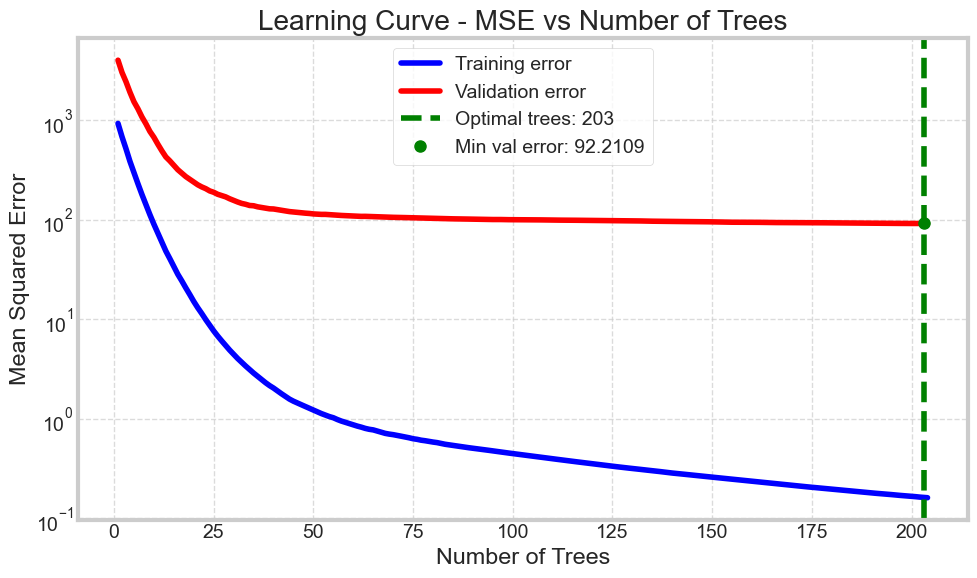

In [12]:
gbrt.plot_learning_curve()

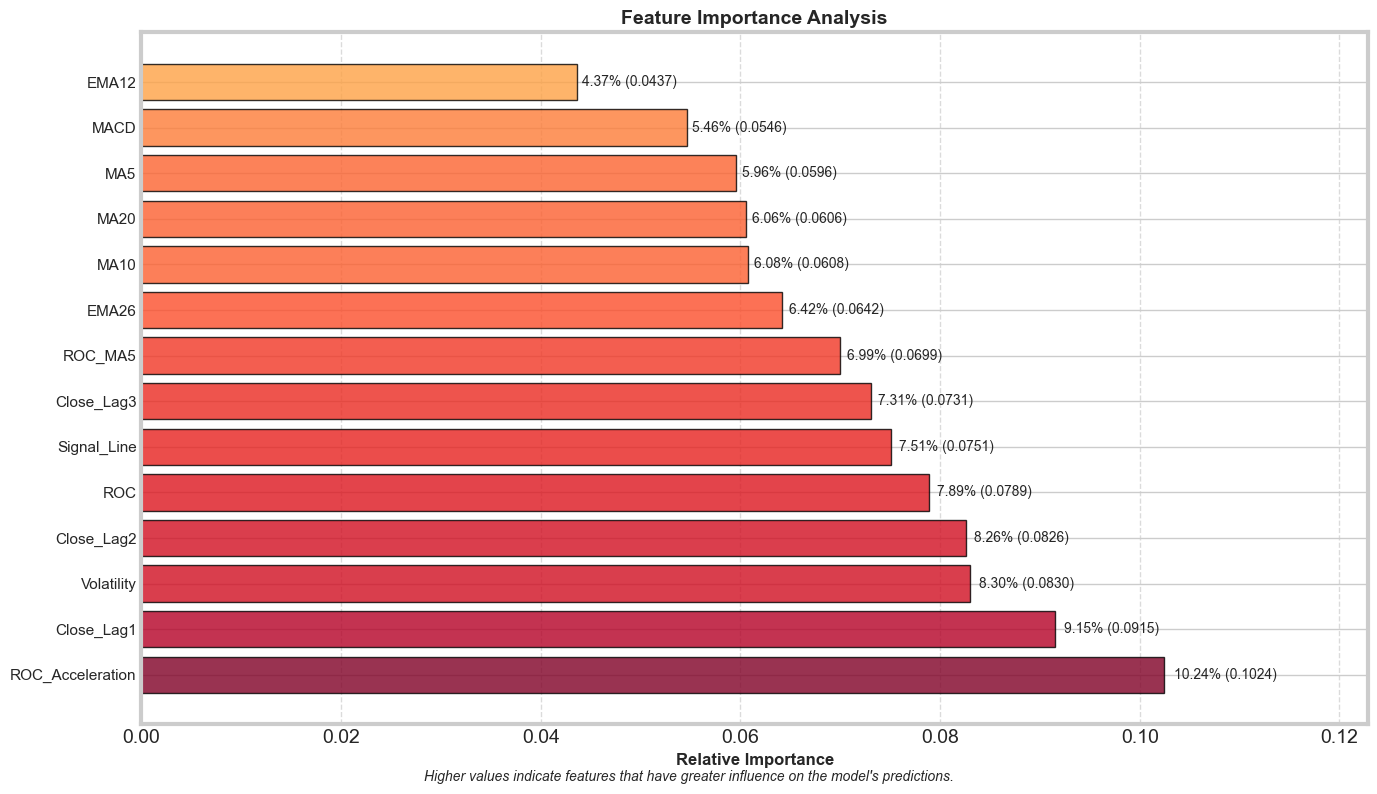

In [13]:
feature_names = df[[col for col in df.columns if col not in ['Close', 'Date']]].columns

feature_importance = gbrt.plot_feature_importance(
    feature_names=feature_names,
    figsize=(14, 8),
)

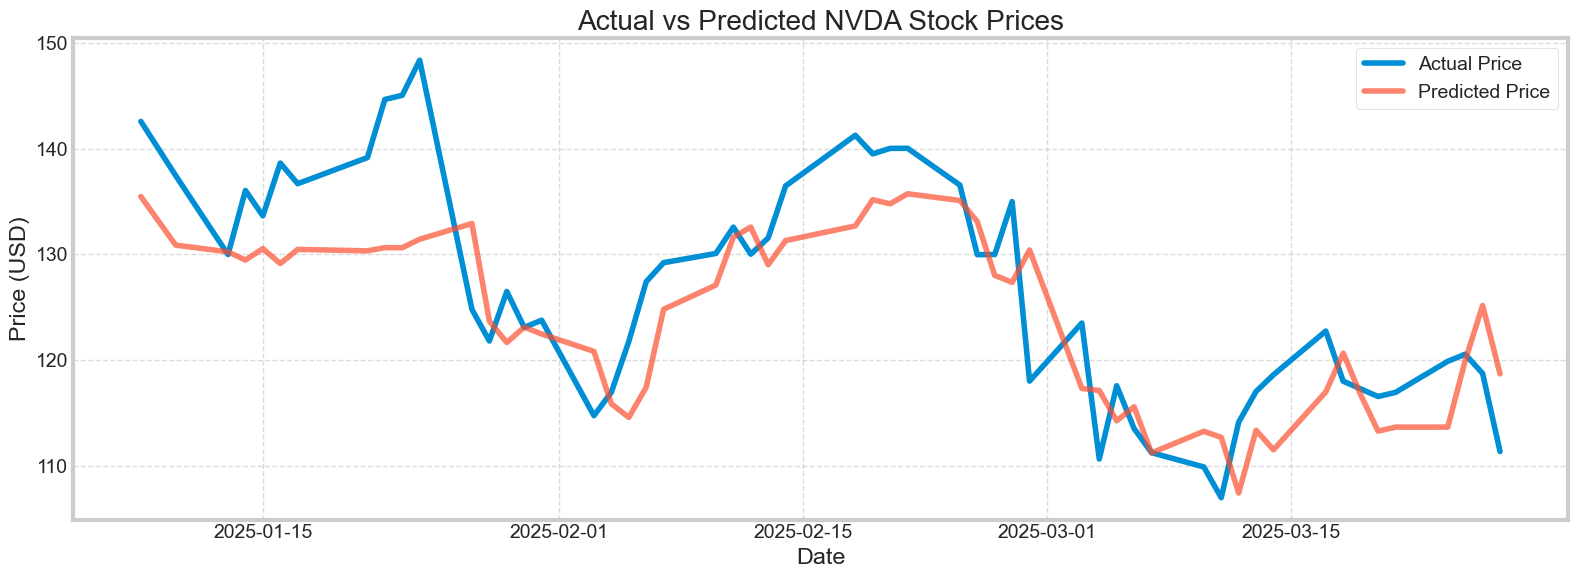

In [14]:
plt.figure(figsize=(16, 6))
plt.title(f'Actual vs Predicted {stock_ticker} Stock Prices')
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual Price')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Predicts the price of Tesla stock

In [17]:
forecast_days = 60

last_date = df['Date'].iloc[-1]
future_dates = []
current_date = last_date
for _ in range(forecast_days):
  current_date += pd.Timedelta(days=1)
  # Skip weekends
  while current_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
    current_date += pd.Timedelta(days=1)
  future_dates.append(current_date)

# Create dataframe with future dates
future_df = pd.DataFrame({'Date': future_dates})
for col in df.columns:
  if col != 'Date':
    future_df[col] = np.nan

# Create forecast dataframe by combining historical and future data
df_forecast = pd.concat([df, future_df], ignore_index=True)
forecast_start_idx = len(df)

# Generate predictions one day at a time
for i in range(forecast_days):
  current_idx = forecast_start_idx + i
  
  # Update lagged values based on previous predictions
  df_forecast.loc[current_idx, 'Close_Lag1'] = df_forecast.loc[current_idx-1, 'Close']
  df_forecast.loc[current_idx, 'Close_Lag2'] = df_forecast.loc[current_idx-1, 'Close_Lag1']
  df_forecast.loc[current_idx, 'Close_Lag3'] = df_forecast.loc[current_idx-1, 'Close_Lag2']
  
  # Calculate moving averages
  df_forecast.loc[current_idx, 'MA5'] = df_forecast.loc[current_idx-5:current_idx-1, 'Close'].mean()
  df_forecast.loc[current_idx, 'MA10'] = df_forecast.loc[current_idx-10:current_idx-1, 'Close'].mean()
  df_forecast.loc[current_idx, 'MA20'] = df_forecast.loc[current_idx-20:current_idx-1, 'Close'].mean()
  
  # Calculate EMA values
  alpha_12 = 2/(12+1)
  alpha_26 = 2/(26+1)
  alpha_9 = 2/(9+1)
  
  # EMA12 calculation
  df_forecast.loc[current_idx, 'EMA12'] = (
    df_forecast.loc[current_idx-1, 'Close'] * alpha_12 + 
    df_forecast.loc[current_idx-1, 'EMA12'] * (1-alpha_12)
  )
  
  # EMA26 calculation
  df_forecast.loc[current_idx, 'EMA26'] = (
    df_forecast.loc[current_idx-1, 'Close'] * alpha_26 + 
    df_forecast.loc[current_idx-1, 'EMA26'] * (1-alpha_26)
  )
  
  # MACD and Signal Line
  df_forecast.loc[current_idx, 'MACD'] = df_forecast.loc[current_idx, 'EMA12'] - df_forecast.loc[current_idx, 'EMA26']
  df_forecast.loc[current_idx, 'Signal_Line'] = (
    df_forecast.loc[current_idx, 'MACD'] * alpha_9 + 
    df_forecast.loc[current_idx-1, 'Signal_Line'] * (1-alpha_9)
  )
  
  # Volatility
  df_forecast.loc[current_idx, 'Volatility'] = df_forecast.loc[current_idx-10:current_idx-1, 'Close'].std()
  
  # Rate of Change (ROC)
  df_forecast.loc[current_idx, 'ROC'] = (
    (df_forecast.loc[current_idx-1, 'Close'] / df_forecast.loc[current_idx-10, 'Close'] - 1) * 100
  )
  df_forecast.loc[current_idx, 'ROC_Acceleration'] = (
    df_forecast.loc[current_idx, 'ROC'] - df_forecast.loc[current_idx-1, 'ROC']
  )
  df_forecast.loc[current_idx, 'ROC_MA5'] = df_forecast.loc[current_idx-5:current_idx, 'ROC'].mean()
  
  # Make prediction using the trained model
  X_features = df_forecast.loc[current_idx, [col for col in df.columns if col not in ['Close', 'Date']]].values.reshape(1, -1)
  predicted_close = gbrt.predict(X_features)[0]
  
  # Add small random noise for natural variation (0.2%)
  noise = np.random.normal(0, 0.002 * predicted_close)
  df_forecast.loc[current_idx, 'Close'] = predicted_close + noise

# Show the last rows of the forecast
df_forecast.tail()

,Date,Close,Close_Lag1,Close_Lag2,Close_Lag3,MA5,MA10,MA20,EMA12,EMA26,MACD,Signal_Line,Volatility,ROC,ROC_Acceleration,ROC_MA5
595,2025-06-13,127.041295,126.597672,125.624671,124.855169,125.370778,124.499585,123.805888,124.696505,124.205832,0.490673,0.209137,1.182027,2.554031,0.404731,1.878763
596,2025-06-16,126.163401,127.041295,126.597672,125.624671,125.798915,124.859229,123.873221,125.057242,124.415866,0.641376,0.295585,1.359293,3.210526,0.656495,2.043782
597,2025-06-17,125.851575,126.163401,127.041295,126.597672,126.056442,125.166622,123.967325,125.227420,124.545313,0.682107,0.372889,1.258439,2.809650,-0.400875,2.265242
598,2025-06-18,125.086121,125.851575,126.163401,127.041295,126.255723,125.480227,124.059907,125.323444,124.642073,0.681371,0.434586,0.926812,1.379625,-1.430025,2.315458
599,2025-06-19,124.752215,125.086121,125.851575,126.163401,126.148013,125.574946,124.254227,125.286933,124.674965,0.611967,0.470062,0.816315,0.266878,-1.112747,2.061668


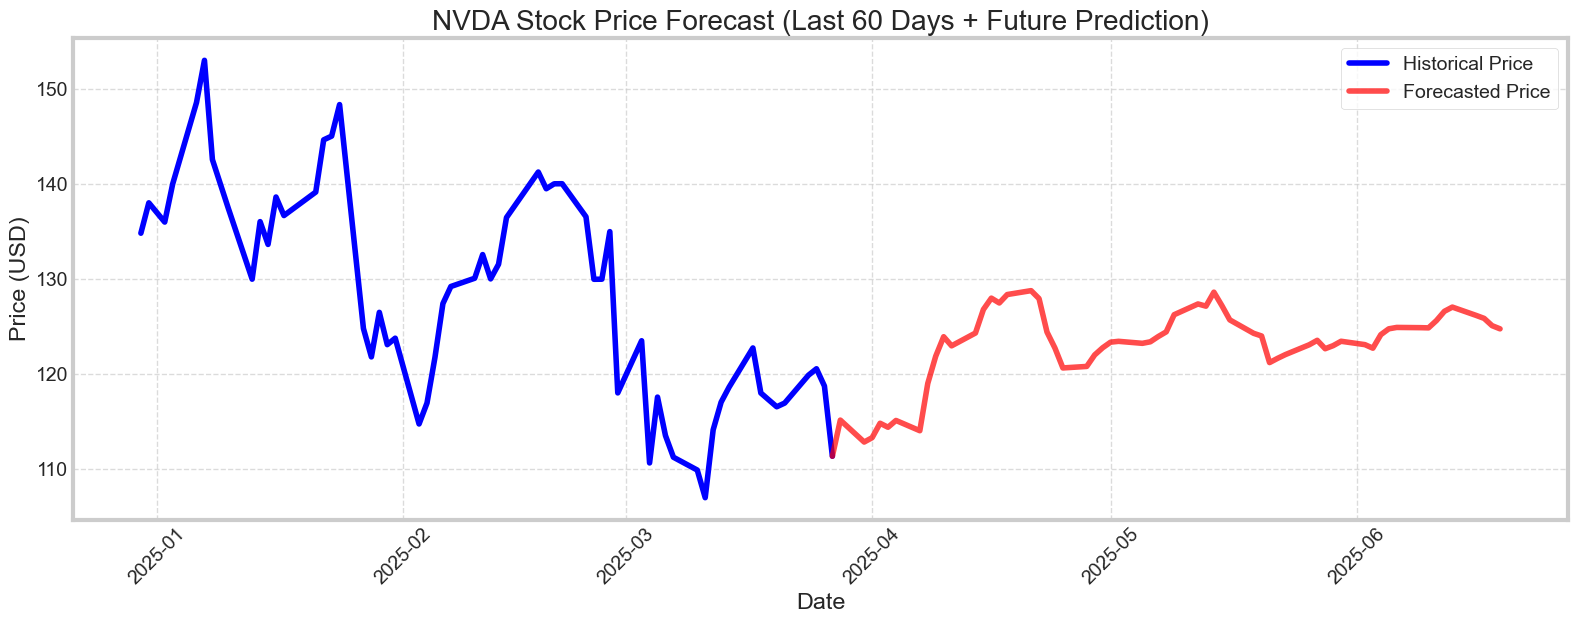

In [20]:
plt.figure(figsize=(16, 6))
plt.title(f'{stock_ticker} Stock Price Forecast (Last 60 Days + Future Prediction)')

# Calculate the start index for showing only last 60 days of historical data
historical_start_idx = max(0, forecast_start_idx - 60)

# Historical price data (last 60 days only)
plt.plot(df_forecast['Date'][historical_start_idx:forecast_start_idx], 
     df_forecast['Close'][historical_start_idx:forecast_start_idx], 
     label='Historical Price', color='blue')

# Forecasted price data
plt.plot(df_forecast['Date'][forecast_start_idx-1:], 
     df_forecast['Close'][forecast_start_idx-1:], 
     label='Forecasted Price', color='red', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()